In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0:'SOS', 1:'EOS'}
        self.n_words = 2 # SOS, EOS 포함

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [30]:
# 유니 코드 문자열을 일반 ASCII로 변환하십시오.
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [31]:
def readLangs(lang1, lang2, reverse=False):
    print('Reading lines..')

    lines = open(f'data/{lang1}-{lang2}.txt', encoding='utf-8').\
            read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [32]:
MAX_LENGTH = 10

eng_prefixes = (
    'i am', 'i m',
    'he is', 'he s',
    'she is', 'she s',
    'you are', 'you re',
    'we are', 'we re',
    'they are', 'they re'
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
            len(p[1].split(' ')) < MAX_LENGTH and \
            p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [33]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print(f'Read {len(pairs)} sentence pairs')
    pairs = filterPairs(pairs)
    print(f'Trimmed to {len(pairs)} sentence pairs')
    print('Counting words ..')
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print('Counted words:')
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [34]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p = 0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [35]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher Forcing O
                decoder_input = target_tensor[:,i].unsqueeze(1)
            else:
                # Teacher Forcing X
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach() # 입력으로 사용할 부분을 히스토리에서 분리

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=1)
        return decoder_outputs, decoder_hidden, None # 학습루프의 일관성 유지를 위해

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [55]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2*hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))

        query = hidden.permute(1,0,2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights
        
        

In [36]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1,-1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                              torch.LongTensor(target_ids).to(device))
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [37]:
input_lang, output_lang, train_dataloader = get_dataloader(4)

Reading lines..
Read 135842 sentence pairs
Trimmed to 12892 sentence pairs
Counting words ..
Counted words:
fra 5228
eng 3434


In [38]:
import time, math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s}s'

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return f'{asMinutes(s)}s (- {asMinutes(rs)}s)'

In [39]:
def train_epoch(dataloader, encoder, decoder, 
                encoder_optimizer, decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)                       
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def train(train_dataloader, encoder, decoder, n_epochs=20, 
          learning_rate=0.001, print_every=100, plot_every=100):
    time_st = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs+1):
        loss = train_epoch(train_dataloader, encoder, decoder,
                          encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'{timeSince(time_st, epoch/n_epochs)} \
            (epoch(%): {epoch}({epoch/n_epochs})) loss_avg: {print_loss_avg:.4f}')

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    plt.plot(plot_losses)
    

In [40]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [41]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Reading lines..
Read 135842 sentence pairs
Trimmed to 12892 sentence pairs
Counting words ..
Counted words:
fra 5228
eng 3434
0m 50.24925684928894ss (- 15m 54.73588013648987ss)             (epoch(%): 4(0.05)) loss_avg: 0.7511
1m 44.027966260910034ss (- 15m 36.25169634819031ss)             (epoch(%): 8(0.1)) loss_avg: 0.5681
2m 38.57053327560425ss (- 14m 58.56635522842407ss)             (epoch(%): 12(0.15)) loss_avg: 0.5499
3m 33.441481828689575ss (- 14m 13.7659273147583ss)             (epoch(%): 16(0.2)) loss_avg: 0.5460
4m 30.069987535476685ss (- 13m 30.209962606430054ss)             (epoch(%): 20(0.25)) loss_avg: 0.5444
5m 26.31242060661316ss (- 12m 41.39564808209752ss)             (epoch(%): 24(0.3)) loss_avg: 0.5439
6m 22.938322067260742ss (- 11m 51.17116955348433ss)             (epoch(%): 28(0.35)) loss_avg: 0.5433
7m 20.843034982681274ss (- 11m 1.2645524740219116ss)             (epoch(%): 32(0.4)) loss_avg: 0.5431
8m 18.370258808135986ss (- 10m 9.119205209943857ss)             (e

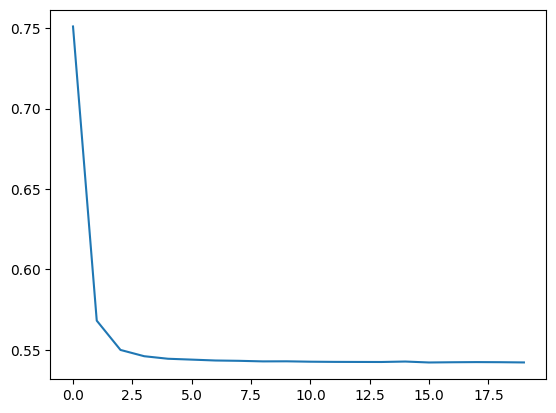

In [43]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, n_epochs=80, 
          learning_rate=0.001, print_every=4, plot_every=4)

In [45]:
_,_,pairs = prepareData('eng','fra',True)

Reading lines..
Read 135842 sentence pairs
Trimmed to 12892 sentence pairs
Counting words ..
Counted words:
fra 5228
eng 3434


In [46]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> il etait assis la les jambes croisees
= he sat there with his legs crossed
< i re almost young of your help <EOS>

> je suis ravi de faire votre connaissance
= i m very pleased to meet you
< i m be working and french <EOS>

> il parait heureux
= he seems happy
< they are leaving when tom could man <EOS>

> elle passe son temps libre a faire des poupees
= she spends her free time making dolls
< i re taking young of it was <EOS>

> elle se rejouit de donner
= she is a cheerful giver
< i re still young of your help <EOS>

> tu n es pas un lache
= you are not a coward
< he re still lucky if tom was <EOS>

> j ai pour ainsi dire trop mange
= i m kind of full
< i re t taking something singer weight <EOS>

> je repare le lave linge
= i am repairing the washing machine
< m sometimes thinking while will never used anymore <EOS>

> il parle mieux l anglais que moi
= he speaks english better than me
< he re sorry but tom s man <EOS>

> c est pour vous que je suis venue
= you re the reason i cam

Reading lines..
Read 135842 sentence pairs
Trimmed to 12892 sentence pairs
Counting words ..
Counted words:
fra 5228
eng 3434
1m 10.257337093353271ss (- 22m 14.889404773712158ss)             (epoch(%): 4(0.05)) loss_avg: 1.7165
2m 25.292256355285645ss (- 21m 47.6303071975708ss)             (epoch(%): 8(0.1)) loss_avg: 0.8567
3m 40.40988636016846ss (- 20m 48.98935604095459ss)             (epoch(%): 12(0.15)) loss_avg: 0.4979
4m 59.4020140171051ss (- 19m 57.60805606842041ss)             (epoch(%): 16(0.2)) loss_avg: 0.3005
6m 16.83611750602722ss (- 18m 50.508352518081665ss)             (epoch(%): 20(0.25)) loss_avg: 0.1931
7m 35.81856369972229ss (- 17m 43.57664863268542ss)             (epoch(%): 24(0.3)) loss_avg: 0.1332
8m 57.72927761077881ss (- 16m 38.640086991446424ss)             (epoch(%): 28(0.35)) loss_avg: 0.0992
10m 19.945104122161865ss (- 15m 29.917656183242798ss)             (epoch(%): 32(0.4)) loss_avg: 0.0782
11m 41.56152081489563ss (- 14m 17.464080995983522ss)             (

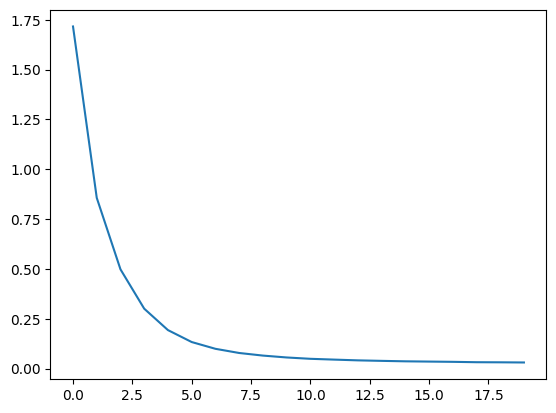

In [56]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, n_epochs=80, 
          learning_rate=0.001, print_every=4, plot_every=4)

In [60]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> nous y sommes bientot
= we re almost there
< we re almost there here <EOS>

> il est riche et puissant
= he s rich and powerful
< he s rich and powerful <EOS>

> c est toi qui m as entraine
= you re the one who trained me
< you re the one who trained me <EOS>

> j ai peur qu il pleuve ce soir
= i m afraid it will rain tonight
< i m afraid it will rain tonight <EOS>

> tu n es pas le premier
= you re not the first
< you re not the first one <EOS>

> c est un voyant
= he is a psychic
< he is a psychic <EOS>

> elle n est pas tres douee au tennis
= she is rather poor at tennis
< she is rather poor at tennis <EOS>

> je cherche seulement un endroit ou dormir
= i m just looking for a place to sleep
< i m just looking for a place to sleep <EOS>

> j en ai assez de jouer
= i m tired of playing games
< i m tired of playing games <EOS>

> je suis completement embrouillee
= i m totally confused
< i m totally confused <EOS>

